In [18]:
#first things first, we need the relevant software that calculates the jacobi radius of a galaxy, as well as other software capable of reading in galaxy info

#we will also need our Hernquist profile code

#to visualize the types of particles that are prone to mass transfer, we will want a modified version of lab 7, where we can draw a sphere with radius r = r_jacobi

# import modules
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.constants import G

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile
from GalaxyMass import ComponentMass
from MassProfile import mEncPlot



In [19]:
#find host mass
def find_host_mass(r,a, Mhalo, Mdisk, Mbulge):
    ''' 
    finds total host mass by summing enclosed Hernquist mass, disk mass, and bulge mass
    inputs:
        r: float, isothermal radius marking the boundary where we include host dark matter, in kpc. 
            It's possible that this should be the separation distance between MW and M31
        a: float, scale factor of host galaxy for the analytic Hernquist profile, in kpc
        Mhalo: float, total halo mass of host galaxy, in units of 10^12Msun
        Mdisk: total disk mass of host galaxy 10^12Msun
        Mbulge: total bulge mass of host galaxy in 10^12Msun
    outputs:
        tot_mass: float, total mass of the host galaxy for the Jacobi radius calculation (in 10^12 Msun)
    '''
    DM_mass = Mhalo * r**2 / (a+r)**2 #uses Hernquist mass equation, keeping in units of 10^12 Msun
    tot_mass = DM_mass + Mdisk + Mbulge
    return tot_mass



#compute the jacobi radius
def Jacobi_radius(Msat, Mhost, r):
    ''' 
    computes the jacobi radius for a galaxy based on the equation R_j = r(M_sat/(2Mhost))^(1/3). 
    As long as Msat and Mhost are in the same units, the units don't matter

    inputs:
        Msat: float, mass of the satellite in arbitrary units. Using total satellite mass 
        (including dark matter which may need to change)
        Mhost: float, mass of host galaxy, including complete disk mass, bulge mass, and dark matter up to 
        the isothermal sphere radius (or center of mass separation). In same arbitrary units as Msat
        r: float, center of mass separation between MW and M31 in kpc

    outputs:
        r_jacobi: float, jacobi radius of the satellite galaxy, beyond which particles may be susceptible to mass loss
    '''
    r_jacobi = r * (Msat / (2*Mhost))**(1/3)
    return r_jacobi


#we need the center of mass separations between MW and M31, which we calculated in HW6
#we stored these values in a file for the 800 snapshots
def RCOM_separation(gal1file, gal2file, time):
    '''
    finds the center of mass separation between MW and M31 at any given time, 
    based on our orbit separation calculation in HW6. A better method is to call the COM class directly
    which I will implement later

    inputs:
        gal1file: str, filename of one galaxy's center of mass evolution over time
        gal2file: str, filename of the other galaxy's center of mass evolution over time
        time: float, time at which we want to calculate the COM position separation, in units of Myr
    outputs:
        separation: float, the separation distance between the two galaxies at the time specified, in kpc
    '''
    g1orbit_data = np.genfromtxt(gal1file,dtype=None,names=True,skip_header=0)
    g2orbit_data = np.genfromtxt(gal2file,dtype=None,names=True,skip_header=0)
    times = g1orbit_data['t']
    index = np.where(abs(times-(time/1000)) < 0.001) #because of rounding, these numbers should be at least this close
    #time is divided by 1000 because these files have time in units of Gyr, but the txt files have time in Myr
    separation = np.sqrt((g1orbit_data['x'][index] - g2orbit_data['x'][index])**2 + 
                         (g1orbit_data['y'][index] - g2orbit_data['y'][index])**2 + 
                         (g1orbit_data['z'][index] - g2orbit_data['z'][index])**2) #distance formula
    return separation

In [20]:
def RotateFrame(posI,velI):
    """a function that will rotate the position and velocity vectors
    so that the disk angular momentum is aligned with z axis. 
    
    PARAMETERS
    ----------
        posI : `array of floats`
             3D array of positions (x,y,z)
        velI : `array of floats`
             3D array of velocities (vx,vy,vz)
             
    RETURNS
    -------
        pos: `array of floats`
            rotated 3D array of positions (x,y,z) such that disk is in the XY plane
        vel: `array of floats`
            rotated 3D array of velocities (vx,vy,vz) such that disk angular momentum vector
            is in the +z direction 
    """
    
    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    # normalize the vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel
def get_disk_info(filename):
    '''
    This function creates the components of a galaxy's disk particles relative to the center of mass, 
    and velocity components relative to the center of mass. This is useful if we want to rotate the viewing frame to 
    be edge on. 

    inputs:
        filename: string
            -galaxy txt file we want to find the radius and velocity components of
    outputs:
        r: numpy array of x,y,z values of the disk particles
        v: numpy array of vx,vy,vz values of the disk particles
    '''
    COMD = CenterOfMass(filename,2)
    COMP = COMD.COM_P(0.1)
    COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])

    # Determine positions of disk particles relative to COM 
    xD = COMD.x - COMP[0].value 
    yD = COMD.y - COMP[1].value 
    zD = COMD.z - COMP[2].value 

    # total magnitude
    rtot = np.sqrt(xD**2 + yD**2 + zD**2)

    # Determine velocities of disk particles relatiev to COM motion
    vxD = COMD.vx - COMV[0].value 
    vyD = COMD.vy - COMV[1].value 
    vzD = COMD.vz - COMV[2].value 

    # total velocity 
    vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)

    # Vectors for r and v 
    r = np.array([xD,yD,zD]).T # transposed 
    v = np.array([vxD,vyD,vzD]).T
    return r, v

In [21]:
def find_outside_particles(r_j, xp,yp,zp, xcom, ycom, zcom):
    ''' 
    creates an array of particles with radii greater than the Jacobi radius, where the radius is 
    the distance from the center of mass of the host galaxy
    inputs: 
        r_j: float, jacobi radius value of satellite galaxy
        xp,yp,zp: each numpy arrays of x,y,z positions of a galaxy's particles
        xcom, ycom, zcom: float values of the galaxy's center of mass position
    outputs:
        outsider_index: numpy array of indices of particles with radii beyond the jacobi radius
    '''
    separations = np.sqrt((xp-xcom)**2 + (yp-ycom)**2 + (zp-zcom)**2)
    outsider_index = np.where(separations > r_j)
    return outsider_index

def find_inside_particles(r_j, xp,yp,zp, xcom, ycom, zcom):
    ''' 
    creates an array of particles with radii less than the Jacobi radius, where the radius is 
    the distance from the center of mass of the host galaxy. Mostly meant for visualization
    inputs: 
        r_j: float, jacobi radius value of satellite galaxy
        xp,yp,zp: each numpy arrays of x,y,z positions of a galaxy's particles
        xcom, ycom, zcom: float values of the galaxy's center of mass position
    outputs:
        insider_index: numpy array of indices of particles with radii beyond the jacobi radius
    '''
    separations = np.sqrt((xp-xcom)**2 + (yp-ycom)**2 + (zp-zcom)**2)
    insider_index = np.where(separations <= r_j)
    return insider_index

In [95]:
def find_ke(vx, vy, vz):
    ''' 
    Function that calculates the specific kinetic energy based on the particle's velocity

    inputs:
        vx: numpy array, x components of particle velocity
        vy: numpy array, y components of particle velocity
        vz: numpy array, z components of particle velocity
    
    outputs:
        ke: numpy array of particle kinetic energies
    '''
    ke = 1/2 * (vx**2 + vy**2 + vz**2)
    return ke

def hernquist_potential(M, a, r):
    ''' 
    function that computes the analytic Hernquist potential based on the formula:
    phi = -GM/(r+a), where M is either halo mass or bulge mass

    inputs:
        M: float, enclosed mass in Msun
        a: float, galaxy scale factor in kpc
        r: float, radius to calculate potential in kpc
    
    outputs:
        phi: float, gravitational potential based on Hernquist profile of either bulge or halo, in units of energy/mass
    '''
    G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
    phi = -G * M / (r + a)
    return phi
def Nagai_potential(Mdisk, x, y, z, rd, zd):
    ''' 
    function that computes the analytic Miamoto-Nagai potential for a disk (see homework 7)

    inputs:
        Mdisk: float, total mass of the disk in Msun
        x,y,z: floats, x, y, and z components of our radius to calculate the potential
        rd: float, disk scale factor in kpc (we assume 5 for now, will probably change)
        zd: float, scale height of disk in kpc. We assume this to be 1/5 of the disk scale factor
    
    outputs:
        phi: float, gravitational potential based on Miamoto-Nagai profile of the disk, in units of energy/mass
    '''
    G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
    R = np.sqrt(x**2 + y**2)
    B = rd + np.sqrt(z**2 + zd**2)
    phi = -G * Mdisk / np.sqrt(R**2 + B**2)
    return phi

In [72]:
def mEncPlot(galaxy, snap, plot_name, a):
    '''
    Plots the total and component-wise mass profile of a galaxy, 
    along with the analytic expectation from the Hernquist profile.

    PARAMETERS
    ----------
    galaxy : `str; 'MW', 'M31', or 'M33'`
        Name of the galaxy to read in
    snap : `int`
        Number of the snapshot to read in
    plot_name : 'str'
        Filename to save the plot under
    a : `float`
        Hernquist scale radius for analytic plot
    '''

    # read in galaxy information
    mProf = MassProfile(galaxy, snap) # mass profile

    # finding filename 
    ilbl = '000' + str(snap) # pad snapshot number
    ilbl = ilbl[-3:] # cut off leading digits so we end up 
      #with a three-digit snap number
    filename='%s_'%(galaxy) + ilbl + '.txt'
        
    M_halo_tot = ComponentMass(filename, 1) * 1e12 * u.Msun 
        # halo mass in Msun

    # radius array in kpc
    r_arr = np.linspace(0.1, 30, 100)

    # calculate mass profiles
    m_halo = mProf.massEnclosed(1, r_arr)
    m_disk = mProf.massEnclosed(2, r_arr)
    if galaxy != 'M33' : 
        # M33 doesn't have a bulge, so skip this if needed
        m_bulge = mProf.massEnclosed(3, r_arr)
    m_tot = mProf.massEnclosedTotal(r_arr)

    # make plot
    fig, ax = plt.subplots()
    # lines
    ax.plot(r_arr, mProf.hernquistMass(r_arr, a, M_halo_tot), 
            c='cyan', label='Analytic Halo, a={} kpc'.format(a))
    ax.plot(r_arr, m_halo, c='b', linestyle=':', label='Halo')
    ax.plot(r_arr, m_disk, c='r', linestyle='-.', label='Disk')
    if galaxy != 'M33' : 
        # M33 doesn't have a bulge, so skip this if needed
        ax.plot(r_arr, m_bulge, c='g', linestyle='--', label='Bulge')
    ax.plot(r_arr, m_tot, c='k', linewidth=3, label='Total')
    # other formatting 
    ax.set(xlabel='r [kpc]', ylabel='$M_{enc}$ $[M_\\odot]$', 
           yscale='log', ylim=[1e8, 5e11], title=galaxy+' Mass Profile')
    ax.legend()
    #save as image
    plt.savefig(plot_name, dpi = 300)

Jacobi radius: $R_j = r  \bigg( \frac{M_{sat}}{2 M_{host}(<r)} \bigg)^{1/3}$

assumptions: satellite is on circular orbit around an isothermal sphere. These are very big assumptions for particles that may not be following circular orbits around interacting galaxies that may not be isothermal spheres, but it does provide a ballpark estimate

For the Milky way, $M_{MW}(<r) = M_{halo} (r) + M_{disk} + M_{bulge}$, $M_{sat} = M_{31\ tot}$, and $r = R_{COM}$ between M31 and MW. Vice versa for M31's Jacobi radius. By the Hernquist profile assumption, $M_{halo}(r) = \frac{M_{halo\ tot} r^2}{(a+r)^2}$

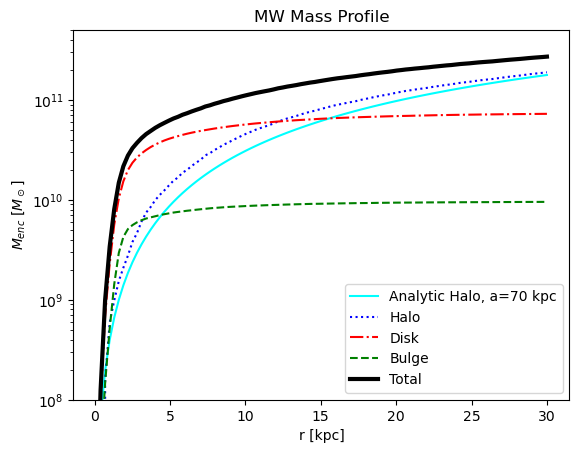

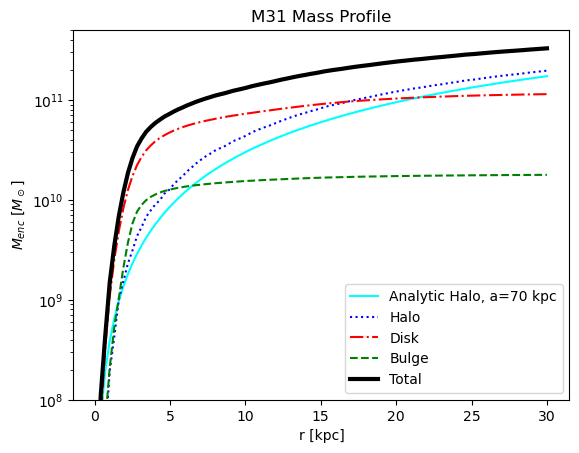

In [90]:
#mEncPlot('MW', 270, 'MW_mass.png', 110)
#mEncPlot('M31', 270, 'MW_mass.png', 200)

#mEncPlot('MW', 300, 'MW_mass.png', 120)
#mEncPlot('M31', 300, 'M31_mass.png', 300)

mEncPlot('MW', 410, 'MW_410_mass.png', 70)
mEncPlot('M31', 410, 'M31_410_mass.png', 70)

In [91]:
#now mass transfer from milky way to M31
#now MW is the satellite, M31 is the host galaxy

MWtime, MWtotal, MWdata = Read('MW_410.txt') #find data for MW at this snapnumber
M31time, M31total, M31data = Read('M31_410.txt') #find data for M31 at this snapnumber

M31_halomass = ComponentMass('M31_410.txt', 1) #recall, units of 10^12 Msun
M31_diskmass = ComponentMass('M31_410.txt', 2) #recall, units of 10^12 Msun
M31_bulgemass = ComponentMass('M31_410.txt', 3) #recall, units of 10^12 Msun
M31_scalefactor = 70 #kpc, from above plot
M31_MW_separation = RCOM_separation('OrbitMW_0_800.txt', 'OrbitM31_0_800.txt', MWtime.value)
#try using massenclosedtotalfunction
M31_hostmass = find_host_mass(M31_MW_separation, M31_scalefactor, M31_halomass, M31_diskmass, M31_bulgemass)
M31_profile = MassProfile('M31', 410)
MW_profile = MassProfile('MW', 410)
#M31_hostmass = M31_profile.massEnclosedTotal(M31_MW_separation) #units of 10^10 Msun
MW_satmass = ComponentMass('MW_410.txt', 1) + ComponentMass('MW_410.txt', 2) + ComponentMass('MW_410.txt', 3)
#MW_satmass = MW_profile.massEnclosedTotal(10000)
MW_Jacobi_Rad = Jacobi_radius(MW_satmass, M31_hostmass, M31_MW_separation)
print(MW_Jacobi_Rad)
#time 300 jacobi radius for MW is 185.95341972 kpc


[14.7308019]


In [92]:
# Compute COM of M31 using disk particles
COMD_MW = CenterOfMass("MW_410.txt",2)
COMP_MW = COMD_MW.COM_P(0.1)
COMV_MW = COMD_MW.COM_V(COMP_MW[0],COMP_MW[1],COMP_MW[2])
# Determine positions of disk particles relative to COM 
xD_MW = COMD_MW.x - COMP_MW[0].value 
yD_MW = COMD_MW.y - COMP_MW[1].value 
zD_MW = COMD_MW.z - COMP_MW[2].value 

# total magnitude
rtot = np.sqrt(xD_MW**2 + yD_MW**2 + zD_MW**2)

# Determine velocities of disk particles relatiev to COM motion
vxD_MW = COMD_MW.vx - COMV_MW[0].value 
vyD_MW = COMD_MW.vy - COMV_MW[1].value 
vzD_MW = COMD_MW.vz - COMV_MW[2].value 

# total velocity 
vtot_MW = np.sqrt(vxD_MW**2 + vyD_MW**2 + vzD_MW**2)

# Vectors for r and v 
r_MW = np.array([xD_MW,yD_MW,zD_MW]).T # transposed 
v_MW = np.array([vxD_MW,vyD_MW,vzD_MW]).T

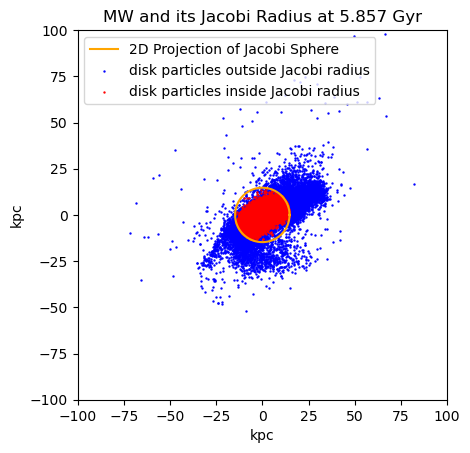

marked particle radii are [16.29003469 18.79732855 17.622262   ... 15.23723558 16.21882529
 20.58043955] kpc which is greater than [14.7308019] kpc


In [94]:
#we need to globally find the x,y,z coordinates of M31's center of mass, similar to our RCOM_separation function
MWorbit_data = np.genfromtxt('OrbitMW_0_800.txt',dtype=None,names=True,skip_header=0)
M31orbit_data = np.genfromtxt('OrbitM31_0_800.txt',dtype=None,names=True,skip_header=0)
times = M31orbit_data['t']
timenow_index = np.where(abs(times-(M31time.value/1000)) < 0.001) #because of rounding, these numbers should be at least this close
M31_xcom = M31orbit_data['x'][timenow_index]
M31_ycom = M31orbit_data['y'][timenow_index]
M31_zcom = M31orbit_data['z'][timenow_index]
M31_vxcom = M31orbit_data['vx'][timenow_index]
M31_vycom = M31orbit_data['vy'][timenow_index]
M31_vzcom = M31orbit_data['vz'][timenow_index]



MW_xcom = MWorbit_data['x'][timenow_index]
MW_ycom = MWorbit_data['y'][timenow_index]
MW_zcom = MWorbit_data['z'][timenow_index]
MW_vxcom = MWorbit_data['vx'][timenow_index]
MW_vycom = MWorbit_data['vy'][timenow_index]
MW_vzcom = MWorbit_data['vz'][timenow_index]

#we'll check DM particles now

disk_index = np.where(MWdata['type'] == 2)
xs = MWdata['x'][disk_index]
ys = MWdata['y'][disk_index]
zs = MWdata['z'][disk_index]

'''
xs = M31data['x']
ys = M31data['y']
zs = M31data['z']
'''
outside_index = find_outside_particles(MW_Jacobi_Rad, xs,ys,zs, MW_xcom, MW_ycom, MW_zcom)
inside_index = find_inside_particles(MW_Jacobi_Rad, xs,ys,zs, MW_xcom, MW_ycom, MW_zcom)
angle = np.linspace( 0 , 2 * np.pi , 150 ) 
#radius = M31_Jacobi_rad
radius = MW_Jacobi_Rad
x = radius * np.cos( angle ) 
y = radius * np.sin( angle )
r_MW, v_MW = get_disk_info('MW_410.txt')
rn_MW, vn_MW = RotateFrame(r_MW, v_MW)
fig, ax = plt.subplots()
ax.plot(x,y, c = 'orange', label = '2D Projection of Jacobi Sphere')
ax.scatter(r_MW[:,0][outside_index], r_MW[:,2][outside_index], s = 0.5, c = 'blue', label = 'disk particles outside Jacobi radius')
ax.scatter(r_MW[:,0][inside_index], r_MW[:,2][inside_index], s = 0.5, c = 'red',label = 'disk particles inside Jacobi radius' )
#plt.hist2d(r_MW[:,0][outside_index], r_MW[:,2][outside_index], bins = 150, norm = LogNorm(), cmap = 'viridis', label = 'disk particles outside Jacobi radius')
#plt.hist2d(r_MW[:,0][inside_index], r_MW[:,2][inside_index], bins = 150, norm = LogNorm(), cmap = 'magma', label = 'disk particles inside Jacobi radius')
#plt.colorbar()
ax.legend(loc = 'upper left')
ax.set_ylim(-100,100)
ax.set_xlim(-100,100)
ax.set_xlabel('kpc')
ax.set_ylabel('kpc')
ax.set_title('MW and its Jacobi Radius at 5.857 Gyr')
ratio = 1.0
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
plt.savefig("MW410_disk", dpi=300)
plt.show()

particle_radii = np.sqrt((MW_xcom - xs[outside_index])**2 + (MW_ycom - ys[outside_index])**2 + (MW_zcom - zs[outside_index])**2)
all_particle_radii = np.sqrt((MW_xcom - xs)**2 + (MW_ycom - ys)**2 + (MW_zcom - zs)**2)
print('marked particle radii are', particle_radii, 'kpc', 
    'which is greater than', MW_Jacobi_Rad, 'kpc')